In [1]:
from io import open
import glob
import os
import unicodedata
import string

In [2]:
# 找到标准ascii码
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # 加上一个 EOS 标记

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# 读入文件 filename, 分行
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# 建立一个词典 category_lines = {category: lines} , lines = [names...]
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0 :
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))


# categories: 18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
O'Neal


In [3]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# category 的 one-hot编码
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor.to(device)

# input 的 one-hot编码 ，从第一个字母到最后一个字母（不包含 EOS）
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor.to(device)

# output 的 one-hot编码 ，从第二个字母到最后的 EOS 符
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li])for li in range(1,len(line))]
    letter_indexes.append(n_letters - 1) # EOS的索引
    return torch.LongTensor(letter_indexes).to(device)



cuda:0


In [4]:
import random

# 从数组 l 中随机选一个元素
def randomChoice(l):
    return l[random.randint(0,len(l)-1)]

# 随机采样一个 category，从该 category 中随机采样一个姓名line
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

# 从一个随机采样的 category-line 对中构建训练样本，
# 包含 category 的tensor, input 的 tensor, 和 target 的 tensors 
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

    
    

In [5]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN,self).__init__() 
        self.hidden_size = hidden_size
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)
        self.o2o = nn.Linear(hidden_size + output_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, category, input, hidden):
        input_combined = torch.cat((category, input, hidden),1)
        hidden = self.i2h(input_combined)
        output = self.i2o(input_combined)
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1,self.hidden_size).to(device)


In [6]:
criterion = nn.NLLLoss()

learning_rate = 0.0005

def train(category_tensor, input_line_tensor, target_line_tensor):
    target_line_tensor.unsqueeze_(-1)
    hidden = rnn.initHidden()

    rnn.zero_grad()

    loss = 0

    for i in range(input_line_tensor.size(0)):
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
        loss += criterion(output, target_line_tensor[i])

    loss.backward()

    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item() / input_line_tensor.size(0)


In [10]:
import time

def timeSince(since):
    now = time.time()
    s = now-since
    return '%dm %ds'%(s//60,s%60)

n_iters = 100000
print_every = 5000
plot_every = 500

all_losses = []
total_loss = 0

n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_letters)
rnn = rnn.to(device)

start = time.time()

for iter in range(1, n_iters + 1):
    output, loss = train(*randomTrainingExample())
    total_loss += loss

    if iter % print_every == 0:
        print('%s (%d %d%%) %.4f' % 
          (timeSince(start),iter, iter/n_iters*100,loss))
    
    if iter % plot_every == 0:
        all_losses.append(total_loss/plot_every)
        total_loss = 0


0m 21s (5000 5%) 3.1131
0m 43s (10000 10%) 3.0381
1m 4s (15000 15%) 2.6815
1m 25s (20000 20%) 3.0040
1m 46s (25000 25%) 3.0916
2m 6s (30000 30%) 1.8668
2m 26s (35000 35%) 2.7345
2m 47s (40000 40%) 1.8517
3m 7s (45000 45%) 3.4005
3m 28s (50000 50%) 1.9611
3m 49s (55000 55%) 2.8826
4m 10s (60000 60%) 2.2253
4m 31s (65000 65%) 2.2987
4m 53s (70000 70%) 3.0623
5m 14s (75000 75%) 3.4069
5m 35s (80000 80%) 2.8392
5m 56s (85000 85%) 1.7129
6m 18s (90000 90%) 2.3341
6m 39s (95000 95%) 2.2673
7m 1s (100000 100%) 2.4354


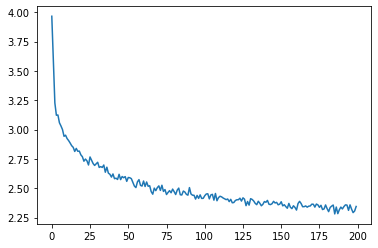

In [19]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.figure()
plt.plot(all_losses)

In [21]:
max_length = 20

def sample(category,start_letter ='A'):
    with torch.no_grad():
        category_tensor = categoryTensor(category)
        input = inputTensor(start_letter)
        hidden = rnn.initHidden()
        
        output_name = start_letter
        
        for i in range(max_length):
            output,hidden = rnn(category_tensor,input[0],hidden)
            topv,topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:
                break
            else:
                letter = all_letters[topi]
                output_name += letter
            input = inputTensor(letter)
            
        return output_name
    
def samples(category,start_letter='ABC'):
    for start_letter in start_letters:
        print(sample(category,start_letter))
        
samples('Russian','RUS')
samples('German','GER')
samples('Spanish','Spa')

NameError: name 'start_letters' is not defined